In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1680-2/model_1680_2.pth
/kaggle/input/1949over/model_1949.pth
/kaggle/input/t4model/model_4.pth
/kaggle/input/image-data-training/Train/low/641.png
/kaggle/input/image-data-training/Train/low/173.png
/kaggle/input/image-data-training/Train/low/491.png
/kaggle/input/image-data-training/Train/low/718.png
/kaggle/input/image-data-training/Train/low/709.png
/kaggle/input/image-data-training/Train/low/248.png
/kaggle/input/image-data-training/Train/low/94.png
/kaggle/input/image-data-training/Train/low/480.png
/kaggle/input/image-data-training/Train/low/236.png
/kaggle/input/image-data-training/Train/low/771.png
/kaggle/input/image-data-training/Train/low/675.png
/kaggle/input/image-data-training/Train/low/48.png
/kaggle/input/image-data-training/Train/low/677.png
/kaggle/input/image-data-training/Train/low/761.png
/kaggle/input/image-data-training/Train/low/655.png
/kaggle/input/image-data-training/Train/low/227.png
/kaggle/input/image-data-training/Train/low/762.png
/kaggle/

In [2]:
pip install pytorch_msssim

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np


low_dir = '/kaggle/input/image-data-training/Train/low'
high_dir = '/kaggle/input/image-data-training/Train/high'


def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):  
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images


low_images = load_images_from_directory(low_dir)
high_images = load_images_from_directory(high_dir)


low_array = np.array(low_images)
high_array = np.array(high_images)


print(f'Low images array shape: {low_array.shape}')
print(f'High images array shape: {high_array.shape}')



Low images array shape: (485, 400, 600, 3)
High images array shape: (485, 400, 600, 3)


# HYPNOTISE MODEL

In [3]:

import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 

class down_samp(nn.Module):
    def __init__(self, in_chan, k):
        super(down_samp, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=k, stride=k)

    def forward_d(self, x):
        
        x = self.pool(x)
        return x

class up_samp(nn.Module):
    def __init__(self, in_chan,out_chan, k):
        super(up_samp, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels=in_chan, out_channels=out_chan, kernel_size=k, stride=k)
        self.conv = nn.Conv2d(in_channels=out_chan, out_channels=out_chan, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.upconv(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

    

class HSC_E_Block(nn.Module):
    def __init__(self):
        super(HSC_E_Block, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=(5,5), padding=2)
        #self.conv_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5,5), padding=2)
        
    def forward1(self, x):
        out_s = self.conv_1(x)
        #out_s = self.conv_2(out_s)
        
        return out_s#256

class SCR_Block(nn.Module):
    def __init__(self, in_chan):
        super(SCR_Block, self).__init__()
        
        self.in_chan = in_chan
        self.conv = nn.Conv2d(in_channels=in_chan, out_channels=in_chan, kernel_size=(3,3), padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels=2*in_chan, out_channels=in_chan, kernel_size=(3,3),padding=1)

    def forward2(self, x):
        #out_scr = self.conv(x)
        #out_scr = self.relu(out_scr)

        out_scr = self.conv(x)
        out_scr = torch.cat((x, out_scr), dim=1)
        out_scr = self.relu(out_scr)
        out_scr = self.conv1(out_scr)

        return out_scr
    
class GLSC_Block(SCR_Block):
    def __init__(self, in_chan, num_blocks):
        super(GLSC_Block, self).__init__(in_chan)
        self.in_chan  = in_chan
        self.num_blocks = num_blocks
        self.conv2 = nn.Conv2d(in_channels=in_chan, out_channels=256, kernel_size=1)
        
    def forward3(self, x):
        out_glsc = x
        for i in range(self.num_blocks):
            out_glsc = self.forward2(out_glsc)
        out_glsc = self.conv2(out_glsc) 
        
        return out_glsc  
    
class HSC_D_Block(nn.Module):
    def __init__(self, in_chan):
        super(HSC_D_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_chan, out_channels=256, kernel_size=(5,5), padding=2)
    
    def forward4(self, x):
        out_hsc_d = self.conv(x)
        return out_hsc_d
        
class RE_Construct(nn.Module):
    def __init__(self, in_chan):
        super(RE_Construct, self).__init__()
        self.convo1 = nn.Conv2d(in_channels=in_chan, out_channels=256, kernel_size=(3,3), padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout2d(p=0.5)

        self.convo2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.con = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3,3), padding=1)

        self.convo3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)

        self.conv_final = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)
        self.sig = nn.Sigmoid()

    def forward_r(self, x):
        final_img = self.relu(self.convo1(x))
        #final_img = self.drop(final_img)

        final_img = self.relu(self.convo2(final_img)) 
        #final_img = self.drop(final_img)

        final_img = torch.cat((final_img, x), dim=1)
        
        final_img = self.relu(self.con(final_img))
        #final_img = self.drop(final_img)

        final_img = self.relu(self.convo3(final_img)) 
        #final_img = self.drop(final_img)

        final_img = self.sig(self.conv_final(final_img))

        return final_img
    
class final_hypnotise_model(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(final_hypnotise_model, self).__init__()

        self.down_a = down_samp(in_chan=3, k=2)
        self.down_b = down_samp(in_chan=3, k=4)

        self.hsc_e = HSC_E_Block()

        self.down_A = down_samp(in_chan=256, k=2)
        self.down_B = down_samp(in_chan=256, k=4)

        self.glsc_1 = GLSC_Block(in_chan=256, num_blocks=1)
        self.glsc_2 = GLSC_Block(in_chan=512, num_blocks=2)
        self.glsc_3 = GLSC_Block(in_chan=768, num_blocks=4)

        self.up_a = up_samp(in_chan=256,out_chan=128,k=2)
        self.up_b = up_samp(in_chan=256,out_chan=128, k=4)  

        self.hsc_d1 = HSC_D_Block(in_chan=384)
        self.hsc_d2 = HSC_D_Block(in_chan=256)
        self.hsc_d3 = HSC_D_Block(in_chan=256)

        self.re_con = RE_Construct(in_chan=384)

    def forward(self, x):
        x_s1 = self.hsc_e.forward1(x)
        x_s2 = self.hsc_e.forward1(self.down_a.forward_d(x))
        #x_s3 = self.hsc_e.forward1(self.down_b.forward_d(x))


        x_s1_1 = self.glsc_1.forward3(x_s1)
        x_s2_1 = self.glsc_2.forward3(torch.cat((self.down_A.forward_d(x_s1),x_s2),dim=1))
        #x_s3_1 = self.glsc_3.forward3(torch.cat((self.down_B.forward_d(x_s1),self.down_A.forward_d(x_s2),x_s3),dim=1))
        


        x_s1_2 = self.hsc_d1.forward4(torch.cat((x_s1_1,self.up_a(x_s2_1)),dim=1))
        x_s2_2 = self.hsc_d2.forward4(x_s2_1)
        #x_s3_2 = self.hsc_d3.forward4(x_s3_1)

        high_img = self.re_con.forward_r(torch.cat((x_s1_2,self.up_a(x_s2_2)),dim=1))
       
        return high_img


## CODE FOR DATA AUGMENTATION(COULDN'T USE BECAUSE OF REASONS MENTIONED IN REPORT)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np





x_tensor = torch.from_numpy(low_array)  
y_tensor = torch.from_numpy(high_array)  


train_transforms = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomResizedCrop(size=(400, 600), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),  
])





In [6]:
from torch.utils.data import Dataset, DataLoader,ConcatDataset


class ImageDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        return image, label


 
#x#
x_test = low_array
y_test = high_array

dataset1 = ImageDataset(x_test, y_test,transform=train_transforms)
dataloader1 = DataLoader(dataset1, batch_size=4, shuffle=True, num_workers=2)

dataset = ImageDataset(x_test, y_test)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2) 

combined_dataset = ConcatDataset([dataset1, dataset])


combined_dataloader = DataLoader(combined_dataset, batch_size=4, shuffle=True, num_workers=2)


## SECOND LOSS THAT I TRIED TO USE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models



def make_gauss_kernel(window_size, sigma):
    gauss = torch.tensor(
        [torch.exp(torch.tensor(-((x - window_size // 2)**2) / (2 * sigma**2))) for x in range(window_size)],
        dtype=torch.float32
    )
    gauss = gauss / gauss.sum()
    return gauss

def make_window(window_size, channels):
    one_d = make_gauss_kernel(window_size, 1.5).unsqueeze(1)
    two_d = one_d.mm(one_d.t()).float().unsqueeze(0).unsqueeze(0)
    window = two_d.expand(channels, 1, window_size, window_size).contiguous()
    return window

def calc_ssim(img1, img2, window_size=11, avg=True):
    _, channels, _, _ = img1.size()
    window = make_window(window_size, channels).to(img1.device)
    
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channels)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channels)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channels) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channels) - mu1_mu2
    
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if avg:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, avg=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.avg = avg

    def forward(self, img1, img2):
        return 1 - calc_ssim(img1, img2, self.window_size, self.avg)

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIMLoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, output, target):
        l1_loss = self.l1_loss(output, target)
        ssim_loss = self.ssim_loss(output, target)
        grad_loss = self.grad_loss(output, target)
        total_loss = 0.1 * ssim_loss + l1_loss + grad_loss
        return total_loss

    def grad_loss(self, output, target):
        output_grad_x = torch.abs(output[:, :, :, :-1] - output[:, :, :, 1:])
        output_grad_y = torch.abs(output[:, :, :-1, :] - output[:, :, 1:, :])
        target_grad_x = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        target_grad_y = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])
        grad_loss_x = F.l1_loss(output_grad_x, target_grad_x)
        grad_loss_y = F.l1_loss(output_grad_y, target_grad_y)
        return grad_loss_x + grad_loss_y


## ORIGINAL LOSS

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from pytorch_msssim import MS_SSIM

class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()
        self.loss = nn.L1Loss()

    def forward(self, input, target):
        return self.loss(input, target)

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg16.features)[:16]).eval()
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        input_features = self.features(input)
        target_features = self.features(target)
        return F.mse_loss(input_features, target_features)

class MS_SSIMLoss(nn.Module):
    def __init__(self):
        super(MS_SSIMLoss, self).__init__()
        self.msssim = MS_SSIM()

    def forward(self, input, target):
        return 1 - self.msssim(input, target)

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.7, gamma=0.5):
        super(CombinedLoss, self).__init__()
        self.l1_loss = L1Loss()
        self.vgg_loss = VGGPerceptualLoss()
        self.ms_ssim_loss = MS_SSIMLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, input, target):
        l1 = self.l1_loss(input, target)
        vgg = self.vgg_loss(input, target)
        ms_ssim = self.ms_ssim_loss(input, target)
        return self.alpha * l1 + self.beta * vgg + self.gamma * ms_ssim

    def to(self, device):
        self.l1_loss.to(device)
        self.vgg_loss.to(device)
        self.ms_ssim_loss.to(device)
        self.vgg_loss.features.to(device)
        return self

In [8]:
import torch.optim as optim

model = final_hypnotise_model(in_channels=3, out_channels=3)  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
model.to(device)

criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,betas=(0.9, 0.999),eps = 10e-8)

Using 2 GPUs


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]  


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


criterion = CombinedLoss().to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


accumulation_steps = 1  

def calculate_psnr(outputs, targets, max_pixel_value=1.0):
    mse = F.mse_loss(outputs, targets)
    psnr = 10 * torch.log10(max_pixel_value**2 / mse)
    return psnr.item()

for epoch in tqdm(range(epochs)):
    model.train()
    epoch_loss = 0
    epoch_psnr = 0

    optimizer.zero_grad()  

    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        outputs = torch.clamp(outputs, 0, 1)

        loss = criterion(outputs, targets)
        
        
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item() * accumulation_steps
        psnr = calculate_psnr(outputs, targets)
        epoch_psnr += psnr
        
        
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()
    
    
    if (i + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    avg_epoch_psnr = epoch_psnr / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss}, Average PSNR: {avg_epoch_psnr:.2f} dB")
    torch.cuda.empty_cache()

In [22]:
import torch

model_path = "/kaggle/working/model_final.pth"
torch.save(model.state_dict(), model_path)
print("Model state dictionary saved as .pth file")

Model state dictionary saved as .pth file


In [23]:
import torch

model = final_hypnotise_model(in_channels=3,out_channels=3)

model_path = "/kaggle/working/model_final.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
model=model.to('cuda')
print("Model loaded successfully")

Model loaded successfully


torch.Size([1, 3, 400, 600])


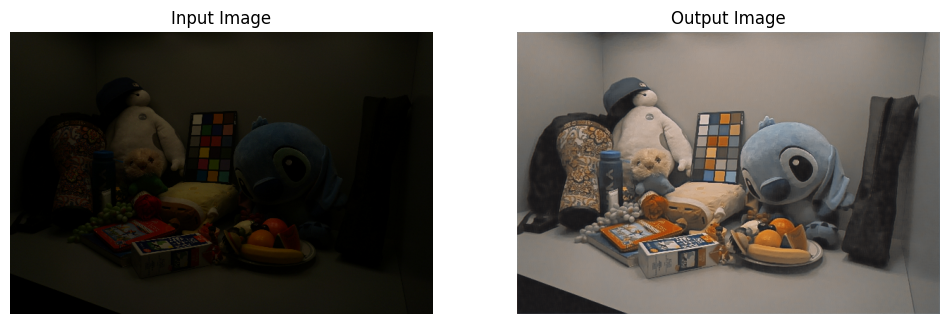

In [25]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    
])


low_sample = "/kaggle/input/image-data-training/Train/low/497.png"
image = Image.open(low_sample).convert('RGB')
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)


print(input_tensor.size())


enhanced = model(input_tensor)


output_image = enhanced.squeeze(0).cpu()  
output_image = transforms.ToPILImage()(output_image)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title('Input Image')
axs[0].axis('off')

axs[1].imshow(output_image)
axs[1].set_title('Output Image')
axs[1].axis('off')

plt.show()


torch.Size([1, 3, 400, 600])


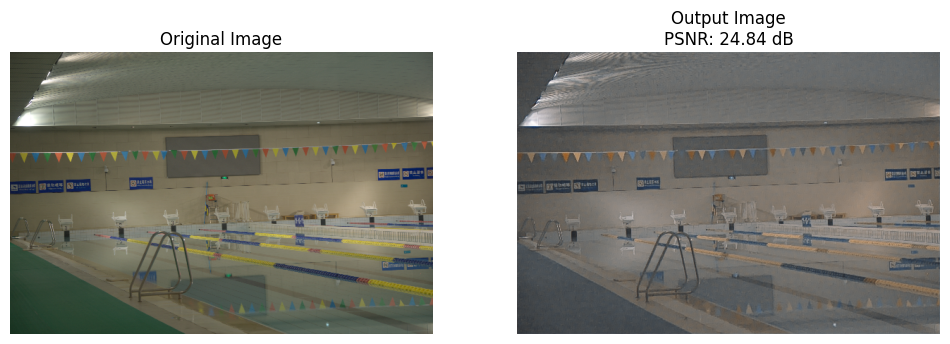

In [24]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    
])


low_sample = "/kaggle/input/image-data-training/Train/low/750.png"
image = Image.open(low_sample).convert('RGB')
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)


high_sample = "/kaggle/input/image-data-training/Train/high/750.png"
image_h = Image.open(high_sample).convert('RGB')
input_tensor_h = transform(image_h)
input_tensor_h = input_tensor_h.unsqueeze(0).to(device)  


print(input_tensor.size())


enhanced = model(input_tensor)


output_image = enhanced.squeeze(0).cpu()  
output_image = transforms.ToPILImage()(output_image)


def calculate_psnr(outputs, targets, max_pixel_value=1.0):
    mse = F.mse_loss(outputs, targets)
    psnr = 10 * torch.log10(max_pixel_value**2 / mse)
    return psnr.item()

psnr_value = calculate_psnr(enhanced, input_tensor_h)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_h)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(output_image)
axs[1].set_title(f'Output Image\nPSNR: {psnr_value:.2f} dB')
axs[1].axis('off')

plt.show()
